In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from os import getcwd, listdir
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft,ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
import librosa
import librosa.display
from librosa import resample

# Import filter function
from neurodsp.filt import filter_signal

# Import simulation code for creating test data
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times

# Import utilities for loading and plotting data
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series

from scipy.signal import hilbert, chirp
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest

In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

In [3]:
group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [4]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna(0).reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna(0).reset_index(drop=1)
    return produced_freq

In [67]:
def load_time_series(subject, session, unit_id):
    subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-3.5][time_point>time_data.min()+3.5]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)
produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [6]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna(0).reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [7]:
def get_subj_df_cue(subject, sess, subj_table):
    cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])


In [69]:
def get_avg_spike(time_table, neural_data, time_data, fs=1000):
    time_point = time_table['starts']
    before = time_table['before_time']
    after = time_table['duration']
    dfs = []

    for item in range(len(neural_data)):
        if time_data[item] > time_point:
            dfs.append(neural_data[item-int(before*fs):item+int(after*fs)])
            break
    return np.mean(np.array(dfs))

In [72]:
def find_full_3_trial(subj_table):
    good_trial = []
    num_sess = len(subj_table['session_id'].unique())
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0]/num_sess == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [73]:
def find_full_3_trial2(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts_y'] > timing_subj.min() + 3.5]
    subj_table = subj_table[subj_table['ends_x'] < timing_subj.max() - 3.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [9]:
xvals = np.linspace(-1.5, 3.5, 5000)

In [18]:
f_low = 70
f_high = 150
SUBJECT = "DBS3003"

f_range = (f_low, f_high)
file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

ecog_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "ecog":
        ecog_chan.append(item)
ecog_chan = np.array(ecog_chan)

time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial(subject_table, timing).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

ecog_mat = np.zeros((subj_df_cue.shape[0], len(ecog_chan), 5000))

for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(ecog_chan)> 0:
                        sig_filt = trial_mat[i2][ecog_chan]
                        sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                        sig_filt = np.nan_to_num(sig_filt)
                        analytic_signal = hilbert(sig_filt)
                        amplitude_envelope = np.abs(analytic_signal)
                        ecog_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]
                    break
                    break

ValueError: could not broadcast input array from shape (58,750) into shape (58,5000)

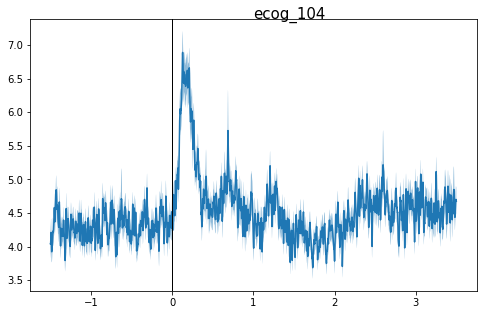

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
elec = 3
elec_mat = ecog_mat[:, elec]
elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
mean = elec_mat.mean(axis=0)
sem = nansem(elec_mat, axis=0)
axs.plot(xvals, mean)
axs.fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
axs.text(0.5, 1, chanlabel[ecog_chan][elec], 
                           transform=axs.transAxes, fontsize=15)
axs.axvline(0, color='k', linewidth=1)

plt.plot();

In [20]:
def area_latency(erp_2d, percentile):
    area_latency = []
    for item in range(erp_2d.shape[0]):
        all_area = abs(erp_2d[item, :]).sum()
        area = 0
        for i2 in range(erp_2d.shape[1]):
            area += abs(erp_2d[item, i2])
            if area >= all_area*percentile/100:
                break
        area_latency.append(i2)
    return np.array(area_latency)

In [19]:
SUBJECT = "DBS3003"

f_range = (70, 150)
file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

ecog_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "ecog":
        ecog_chan.append(item)

time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial(subject_table).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

ecog_mat = np.zeros((subj_df_cue.shape[0], len(ecog_chan), 750))

for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(ecog_chan)> 0:
                        sig_filt = trial_mat[i2][ecog_chan]
                        sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                        sig_filt = np.nan_to_num(sig_filt)
                        analytic_signal = hilbert(sig_filt)
                        amplitude_envelope = np.abs(analytic_signal)
                        ecog_mat[item] = amplitude_envelope[:, i3:i3+750]
                    break
                    break

In [24]:
elec_mat = ecog_mat[:, elec]
elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]


trial_argmax = []
for trial_num in range(elec_mat.shape[0]):
    trial_argmax.append(elec_mat[trial_num].argmax())
    
np.array(trial_argmax).mean()
area_latency(elec_mat, 10).mean()
area_latency(elec_mat, 50).mean()


274.41279069767444

81.38372093023256

342.1162790697674

In [33]:
cue_ecog = pd.read_csv('ecog_cue.csv').iloc[:, :2]
#cue_unit = cue_unit[cue_unit['Cue dir'] == "+"]
cue_ecog.head()

,subj,channel
0,DBS3003,2
1,DBS3003,3
2,DBS3003,4
3,DBS3003,5
4,DBS3003,6


In [36]:
cue_ecog.iloc[2].subj

'DBS3003'

In [52]:
area_onset = []
area_peak = []
arg_peak = []

for i2 in range(len(cue_ecog)):
    print(i2)
    SUBJECT = cue_ecog.iloc[i2].subj
    elec = cue_ecog.iloc[i2].channel
    
    f_range = (70, 150)
    file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
    subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

    chanlabel = []
    for item in range(subj_mat['label'].shape[0]):
        chanlabel.append(subj_mat['label'][item][0][0][0])
    chanlabel = np.array(chanlabel)

    fs = subj_mat['fsample'][0][0]
    nChans = len(subj_mat['label'])
    nTrials = len(subj_mat['trial'][0])

    ecog_chan = []
    for item in range(nChans):
        if chanlabel[item][:4] == "ecog":
            ecog_chan.append(item)

    time_mat = subj_mat['time'][0]
    trial_mat = subj_mat['trial'][0]

    subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
    subject_table = find_full_3_trial(subject_table).reset_index(drop=1)
    subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

    cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
    subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

    ecog_mat = np.zeros((subj_df_cue.shape[0], 750))

    for item in range(subj_df_cue.shape[0]):
        time_point = subj_df_cue.iloc[item].starts_y
        for i2 in range(nTrials):
            time_min = time_mat[i2][0].min()
            time_max = time_mat[i2][0].max()
            if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
                for i3 in range(len(time_mat[i2][0])):
                    if time_mat[i2][0][i3] > time_point:
                        if len(ecog_chan)> 0:
                            sig_filt = trial_mat[i2][ecog_chan][elec]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            ecog_mat[item] = amplitude_envelope[i3:i3+750]
                        break
                        break
                        
    #elec_mat = ecog_mat[:, elec]
    elec_mat = ecog_mat[~np.all(ecog_mat == 0, axis=1)]

    trial_argmax = []
    for trial_num in range(elec_mat.shape[0]):
        trial_argmax.append(elec_mat[trial_num].argmax())

    arg_peak.append(np.array(trial_argmax).mean())
    area_onset.append(area_latency(elec_mat, 10).mean())
    area_peak.append(area_latency(elec_mat, 50).mean())


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


IndexError: index 156 is out of bounds for axis 0 with size 126

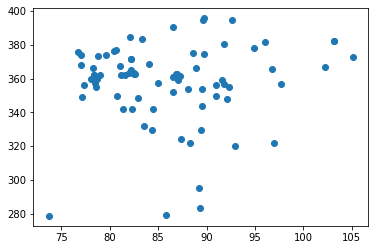

In [53]:
plt.scatter(area_onset, area_peak)

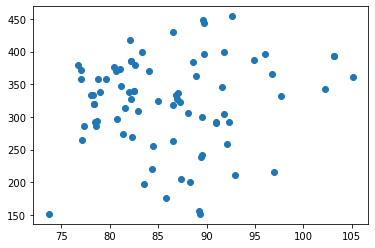

In [54]:
plt.scatter(area_onset, arg_peak)

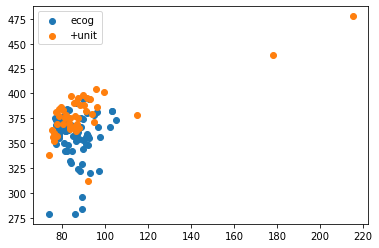

In [85]:
plt.scatter(area_onset_ecog, area_peak_ecog, label='ecog')
plt.scatter(area_onset_unit_activation, area_peak_unit_activation, label='+unit')
plt.legend();

In [ ]:
np.array(area_onset_ecog).mean()
np.array(area_peak_ecog).mean()
np.array(arg_peak_ecog).mean()

np.array(area_onset_unit_activation).mean()
np.array(area_peak_unit_activation).mean()
np.array(arg_peak_unit_activation).mean()

In [58]:
area_onset_ecog = area_onset
area_peak_ecog = area_peak
arg_peak_ecog = arg_peak

In [57]:
np.array(area_onset).mean()
np.array(area_peak).mean()
np.array(arg_peak).mean()

86.07753847512689

357.53325536710037

321.0185556196665

In [81]:
cue_unit = pd.read_csv('cue_unit.csv', index_col=0)
cue_unit = cue_unit[cue_unit['Cue dir'] == "+"]
cue_unit.shape

(44, 15)

In [94]:
area_onset = []
area_peak = []
arg_peak = []

for number_elec in cue_unit.index:
    print(number_elec)
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]

    timing, neural_df = load_time_series(SUBJECT, session, contact)
    neural_df = zscore(neural_df)
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial2(subj_df_cue, timing)
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

    relative_time = cue_start_1
    spike_mat = get_df(relative_time, neural_df, timing, after=0.75, before=0)
    #spike_mat = zscore(spike_mat, axis=1)
    trial_argmax = []
    for trial_num in range(spike_mat.shape[0]):
        trial_argmax.append(spike_mat[trial_num].argmax())

    arg_peak.append(np.array(trial_argmax).mean())
    area_onset.append(area_latency(spike_mat, 10).mean())
    area_peak.append(area_latency(spike_mat, 50).mean())

24
28
29
31
34
37
43
59
60
62
65
66
70
71
72
74
84
90
95
96
97
99
110
111
114
126
142
143
144
148
163
166
168
175
176
180
184
185
189
196
199
205
208
215


In [95]:
area_onset_unit_activation = area_onset
area_peak_unit_activation = area_peak
arg_peak_unit_activation = arg_peak

In [78]:
cue_unit_depression = pd.read_csv('cue_unit.csv', index_col=0)
cue_unit_depression = cue_unit_depression[cue_unit_depression['Cue dir'] == "-"]
cue_unit_depression.shape

(42, 15)

In [96]:
area_onset_depression = []
area_peak_depression = []
arg_peak_depression = []

for number_elec in cue_unit_depression.index:
    print(number_elec)
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]

    timing, neural_df = load_time_series(SUBJECT, session, contact)
    neural_df = zscore(neural_df)
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial2(subj_df_cue, timing)
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']

    relative_time = cue_start_1
    spike_mat = get_df(relative_time, neural_df, timing, after=0.75, before=0) * -1
    #spike_mat = zscore(spike_mat, axis=1)
    trial_argmax = []
    for trial_num in range(spike_mat.shape[0]):
        trial_argmax.append(spike_mat[trial_num].argmax())

    arg_peak_depression.append(np.array(trial_argmax).mean())
    area_onset_depression.append(area_latency(spike_mat, 10).mean())
    area_peak_depression.append(area_latency(spike_mat, 50).mean())

26
30
32
42
48
49
50
52
56
57
58
67
68
78
79
83
87
101
107
112
116
117
120
122
123
128
129
134
149
153
155
160
161
162
165
171
187
202
203
216
217
218


In [97]:
np.array(area_onset_ecog).mean()
np.array(area_peak_ecog).mean()
np.array(arg_peak_ecog).mean()

np.array(area_onset_unit_activation).mean()
np.array(area_peak_unit_activation).mean()
np.array(arg_peak_unit_activation).mean()

np.array(area_onset_depression).mean()
np.array(area_peak_depression).mean()
np.array(arg_peak_depression).mean()

86.07753847512689

357.53325536710037

321.0185556196665

87.97347362213772

375.12223529598117

386.49651348832055

86.06680179909002

369.3645272325565

346.8648839611039

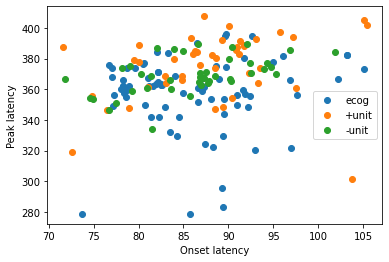

In [109]:
plt.scatter(area_onset_ecog, area_peak_ecog, label='ecog')
plt.scatter(area_onset_unit_activation, area_peak_unit_activation, label='+unit')
plt.scatter(area_onset_depression, area_peak_depression, label='-unit')
#plt.xlim(60, 150)
#plt.ylim(250, 450)
plt.xlabel('Onset latency')
plt.ylabel('Peak latency')

plt.legend();

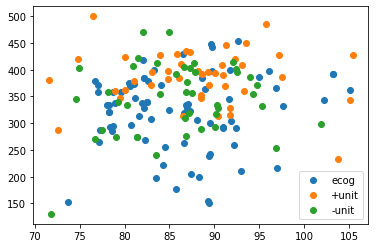

In [105]:
plt.scatter(area_onset_ecog, arg_peak_ecog, label='ecog')
plt.scatter(area_onset_unit_activation, arg_peak_unit_activation, label='+unit')
plt.scatter(area_onset_depression, arg_peak_depression, label='-unit')
#plt.xlim(60, 150)
#plt.ylim(250, 450)

plt.legend();

In [134]:
np.mean(area_peak_ecog)
np.mean(area_peak_unit_activation)
np.mean(area_peak_depression)

np.mean(area_onset_ecog)
np.mean(area_onset_unit_activation)
np.mean(area_onset_depression)

357.53325536710037

375.12223529598117

369.3645272325565

86.07753847512689

87.97347362213772

86.06680179909002

In [1]:
np.mean(arg_peak_unit_activation)
np.mean(arg_peak_depression)

NameError: name 'np' is not defined

In [129]:
f_oneway(area_peak_ecog, area_peak_unit_activation)
f_oneway(area_peak_ecog, area_peak_depression)
f_oneway(area_peak_unit_activation, area_peak_depression)

F_onewayResult(statistic=16.350129022333793, pvalue=9.342864019606927e-05)

F_onewayResult(statistic=9.059700417514025, pvalue=0.0031959787423982444)

F_onewayResult(statistic=2.296792989127589, pvalue=0.13339559591297726)

In [128]:
f_oneway(area_onset_ecog, area_onset_unit_activation)
f_oneway(area_onset_ecog, area_onset_depression)

F_onewayResult(statistic=1.971531504200585, pvalue=0.16286823905512432)

F_onewayResult(statistic=6.844930291848669e-05, pvalue=0.9934128208438644)

In [106]:
f_oneway(arg_peak_ecog, arg_peak_unit_activation)
f_oneway(arg_peak_ecog, arg_peak_depression)

F_onewayResult(statistic=29.721065878723337, pvalue=2.7107916912571284e-07)

F_onewayResult(statistic=3.8584344250539644, pvalue=0.05184747176945719)

In [126]:
label_ecog_peak = np.repeat('ecog', len(area_peak_ecog))
label_unit_acti_peak = np.repeat('unit_activation', len(area_peak_unit_activation))
label_unit_dep_peak = np.repeat('unit_depression', len(area_peak_depression))
label_peak = np.concatenate((label_ecog_peak, label_unit_acti_peak, label_unit_dep_peak))
peak_val = np.concatenate((area_peak_ecog, area_peak_unit_activation, area_peak_depression))
num_peak = np.repeat('peak', len(label_peak))

label_ecog_onset = np.repeat('ecog', len(area_onset_ecog))
label_unit_acti_onset = np.repeat('unit_activation', len(area_onset_unit_activation))
label_unit_dep_onset = np.repeat('unit_depression', len(area_onset_depression))
label_onset = np.concatenate((label_ecog_onset, label_unit_acti_onset, label_unit_dep_onset))
onset_val = np.concatenate((area_onset_ecog, area_onset_unit_activation, area_onset_depression))
num_onset = np.repeat('onset', len(label_onset))

delay = np.concatenate((peak_val, onset_val))
onset_peak = np.concatenate((num_peak, num_onset))
ecog_unit = np.concatenate((label_peak, label_onset))

df_delay = pd.DataFrame({'delay':delay, 'onset_peak':onset_peak, 'ecog_unit':ecog_unit})

<AxesSubplot:>

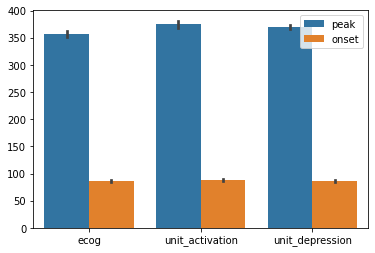

In [127]:
sns.barplot(data=df_delay, x=ecog_unit, y=delay, hue=onset_peak)


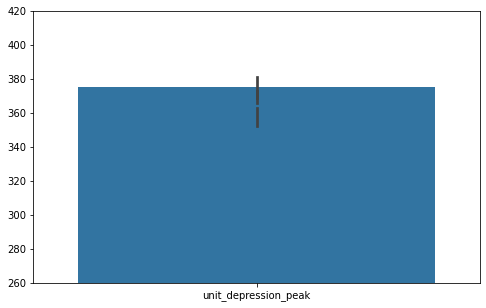

In [117]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(label_ecog_peak, area_peak_ecog, ax=axs)
sns.barplot(label_unit_acti_peak, area_peak_unit_activation, ax=axs)
sns.barplot(label_unit_dep_peak, area_peak_depression, ax=axs)
axs.set_ylim(260, 420);